<a href="https://colab.research.google.com/github/braveenth/garmin-running-llm/blob/main/Garmin_Running_LLM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Garmin Running LLM Analysis 🏃
By: Braveenth Rasanayagam

---

The goal of this Jupyter Notebook is to have reuseable code that facilitates the prompting and analysis of your your Garmin-tracked runs by LLMs.

This was built to help train for a half-marathon, and you can use it for your fitness activities.

I solved the context length limitations imposed by various LLM models by splitting the data using even rows, which is a method to reduce the number of data points. I am also considering other mathematical methods of reducing the number of data points.

Please note that I am not responsible or liable for your use of this application. Please use this at your own risk and consult with a health care professional.


## Steps to Use:
Using OpenAI's ChatGPT API:

1.   Obtain an OpenAI API Key here: https://platform.openai.com/api-keys
2.   Add OpenAI API Key as a Colab secret value named 'OPENAI_API_KEY'
3.   Obtain .fit file from Garmin Connect
4.   Upload .fit file to Colab files
5.   Specify path to .fit file in notebook form

## Steps to Contribute:
Submit a pull-request or message me!
MIT License

## Additional Links
*   [runw.ai](https://www.runw.ai/)
*   [Instagram - runw.ai](https://www.instagram.com/runw.ai.run/)


In [2]:
!pip install garmin-fit-sdk
!pip install tiktoken
!pip install openai

In [3]:
# Lets start by obtaining the path to the .fit file
fit_file = "/content/14976644173_ACTIVITY.fit" # @param {type:"string"}

In [4]:
# This is for when the program runs outside of Colab

import os
from openai import OpenAI
colabEnvironment = False

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    colabEnvironment = True
    openai_api_key = userdata.get('OPENAI_API_KEY')
    client = OpenAI(api_key=openai_api_key)

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    client = OpenAI(api_key=openai_api_key)
    fit_file = os.environ.get('FIT_FILE_PATH')

Running on Google Colab


In [5]:
# Lets describe an existing run that I have completed. We will use the fit file from Garmin Connect.
# In the future, we will retrieve this using Garmin's API.
# Lets use the garmin-fit-sdk here

from garmin_fit_sdk import Decoder, Stream

stream = Stream.from_file(fit_file)
decoder = Decoder(stream)
messages, errors = decoder.read()

print(errors)
# print(messages)

[]


In [6]:
file_messages = messages['file_id_mesgs']

duration_of_activity = messages['activity_mesgs'][0]['total_timer_time']
activity_record_messages = messages['record_mesgs']

# for activity_message in activity_record_messages:
#   print(activity_message)
#print(messages['user_profile_mesgs'])
#print(messages['file_id_mesgs'])

# Information about the units
# 'distance' - metres

In [7]:
# Lets get this information into a Pandas Dataframe

import pandas as pd

df = pd.DataFrame(activity_record_messages)
# Lets remove columns that are currently not necessary

df_with_relevant_information = df.drop(['cycle_length16', 'enhanced_speed','fractional_cadence', 135, 136], axis=1)
display(df_with_relevant_information)

,timestamp,distance,heart_rate,cadence,temperature
0,2024-04-19 13:39:55+00:00,0.00,71,0,28
1,2024-04-19 13:39:56+00:00,0.00,74,0,28
2,2024-04-19 13:40:00+00:00,0.00,77,60,28
3,2024-04-19 13:40:03+00:00,0.00,81,55,28
4,2024-04-19 13:40:09+00:00,0.39,85,54,28
...,...,...,...,...,...
464,2024-04-19 14:20:37+00:00,6730.98,184,75,25
465,2024-04-19 14:20:43+00:00,6744.21,185,75,25
466,2024-04-19 14:20:49+00:00,6757.48,184,76,25
467,2024-04-19 14:20:55+00:00,6770.75,184,75,25


In [8]:
# Lets use the timestamp to get additional information

df2 = df_with_relevant_information

startDateTime = df.iloc[0]['timestamp']
endDateTime = df.iloc[-1]['timestamp']
print(startDateTime)
print(endDateTime)

time_diff = endDateTime - startDateTime
print(time_diff)
#df2['Time (min)'] = df2['timestamp']
#df2['Pace (min/km)'] = df2['Time (min)'] / df2['Distance (km)']

df2['seconds'] = df['timestamp'].astype('int64') // 1e9

specific_value3 = df2.loc[0, 'seconds']
print(specific_value3)
df2['activity_duration_seconds'] = df2['seconds'] - specific_value3


#display(df2)

df_original = df2.drop(['timestamp', 'seconds'], axis=1)
#display(df3)


2024-04-19 13:39:55+00:00
2024-04-19 14:20:57+00:00
0 days 00:41:02
1713533995.0


In [9]:
# Lets calculate Derivatives here
import numpy as np

# 1. Distance and Speed
#    First Derivative (Velocity)
df_original['velocity'] = np.gradient(df_original['distance'], df_original['activity_duration_seconds'])

#    Second Derivative (Acceleration)
df_original['acceleration'] = np.gradient(df_original['velocity'], df_original['activity_duration_seconds'])


# 2. Heart Rate Dynamics
#    First Derivative
df_original['heart_rate_dynamics'] = np.gradient(df_original['heart_rate'], df_original['activity_duration_seconds'])


# 3. Cadence Variability
#    First Derivative
df_original['cadence_variability'] = np.gradient(df_original['cadence'], df_original['activity_duration_seconds'])


# 4. Temperature Effects
#    First Derivative
df_original['temperature_effects'] = np.gradient(df_original['temperature'], df_original['activity_duration_seconds'])


display(df_original)

,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,71,0,28,0.0,0.000000,0.000000,3.000000,0.000000,0.000000e+00
1,0.00,74,0,28,1.0,0.000000,0.000000,2.550000,3.000000,-1.998401e-15
2,0.00,77,60,28,5.0,0.000000,0.004127,1.083333,5.476190,0.000000e+00
3,0.00,81,55,28,8.0,0.021667,0.033651,1.111111,-1.166667,0.000000e+00
4,0.39,85,54,28,14.0,0.540714,0.140317,-4.190476,-0.023810,-3.552714e-15
...,...,...,...,...,...,...,...,...,...,...
464,6730.98,184,75,25,2442.0,2.203333,0.000486,0.000000,0.000000,0.000000e+00
465,6744.21,185,75,25,2448.0,2.208333,0.000694,0.000000,0.083333,0.000000e+00
466,6757.48,184,76,25,2454.0,2.211667,0.000174,-0.083333,0.000000,0.000000e+00
467,6770.75,184,75,25,2460.0,2.210417,-0.000208,0.000000,0.708333,1.776357e-15


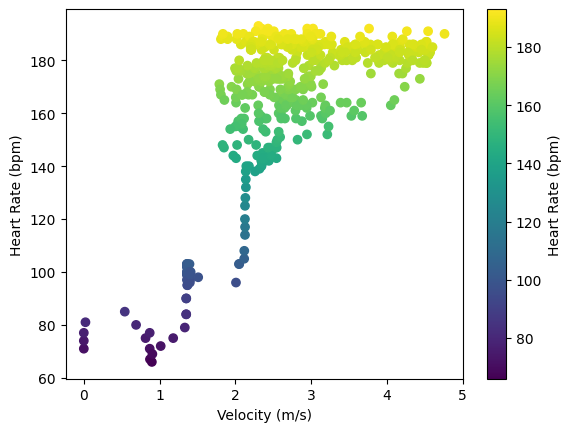

In [10]:
# @title Velocity vs Heart Rate

import matplotlib.pyplot as plt
plt.scatter(df_original['velocity'], df_original['heart_rate'], c=df_original['heart_rate'], cmap='viridis')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Heart Rate (bpm)')
_ = plt.colorbar(label='Heart Rate (bpm)')

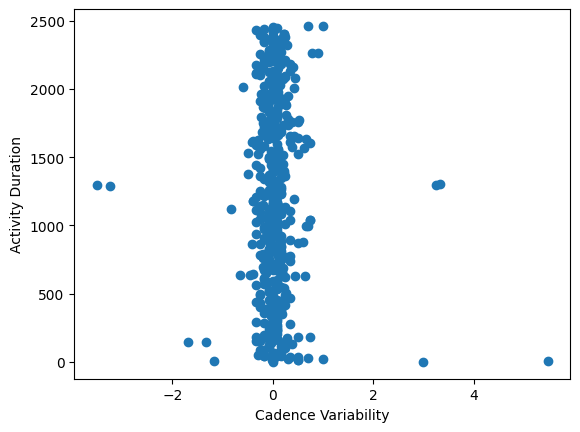

In [12]:
# @title Cadence Variability vs Activity Duration

import matplotlib.pyplot as plt
plt.scatter(df_original['cadence_variability'], df_original['activity_duration_seconds'])
plt.xlabel('Cadence Variability')
_ = plt.ylabel('Activity Duration')

In [13]:
import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")


# Get the Dataframe to a String
df_string = df_original.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))

#Lets get the token size to be appropriate
# The iloc operation will allow us to select rows at specified internals.
# If we use iloc[::2], this is a slicing option to include every other row
# starting from the first row.

target_tokens = 14000
df_token_limitation = df_original

while(len(enc.encode(df_token_limitation.to_string())) > target_tokens):
  df_token_limitation = df_token_limitation.iloc[::2]

display(df_token_limitation)

df_reduced_string = df_token_limitation.to_string()
print ("Number of tokens in resized input prompt ", len(enc.encode(df_reduced_string)))

Number of tokens in input prompt  29990


,distance,heart_rate,cadence,temperature,activity_duration_seconds,velocity,acceleration,heart_rate_dynamics,cadence_variability,temperature_effects
0,0.00,71,0,28,0.0,0.000000,0.000000e+00,3.000000,0.000000,0.000000e+00
4,0.39,85,54,28,14.0,0.540714,1.403175e-01,-4.190476,-0.023810,-3.552714e-15
8,3.51,71,55,28,18.0,0.870000,1.547619e-03,-5.000000,0.000000,0.000000e+00
12,16.97,72,69,28,33.0,1.015000,6.875000e-02,1.500000,0.500000,0.000000e+00
16,28.44,84,70,28,42.0,1.351667,9.436896e-16,1.000000,-0.166667,1.776357e-15
...,...,...,...,...,...,...,...,...,...,...
452,6559.50,189,81,24,2372.0,2.997500,-3.298611e-02,-0.083333,-0.166667,8.333333e-02
456,6626.24,188,79,25,2396.0,2.570000,-1.962500e-02,-0.166667,-0.250000,0.000000e+00
460,6678.04,187,77,25,2418.0,2.232500,-3.541667e-03,-0.083333,0.000000,0.000000e+00
464,6730.98,184,75,25,2442.0,2.203333,4.861111e-04,0.000000,0.000000,0.000000e+00


Number of tokens in resized input prompt  7566


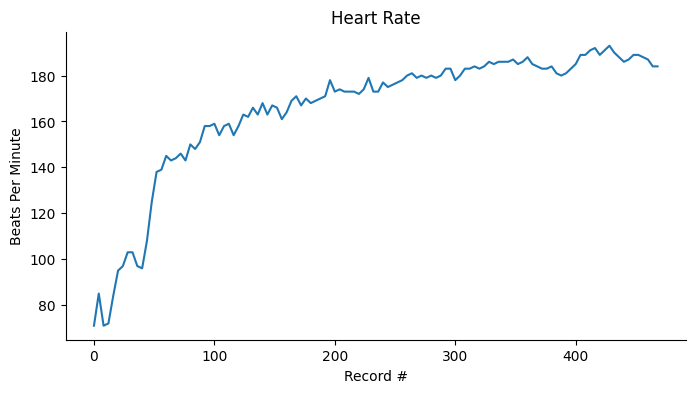

In [17]:
# @title Heart Rate

from matplotlib import pyplot as plt
df_token_limitation['heart_rate'].plot(kind='line', figsize=(8, 4), title='Heart Rate')
plt.xlabel('Record #')
plt.ylabel('Beats Per Minute')
plt.gca().spines[['top', 'right']].set_visible(False)

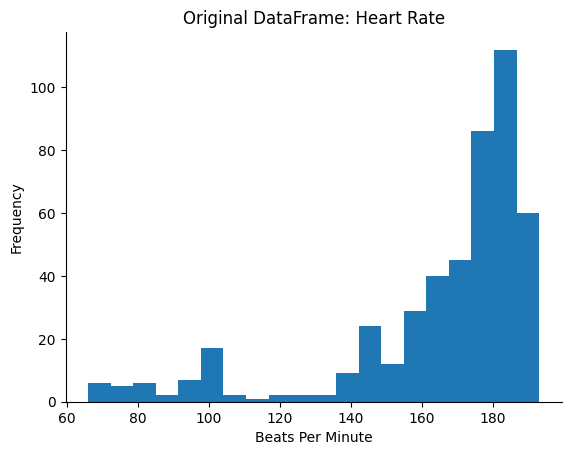

In [18]:
# Visualize Pace from original DF
from matplotlib import pyplot as plt
df['heart_rate'].plot(kind='hist', bins=20, title='Original DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

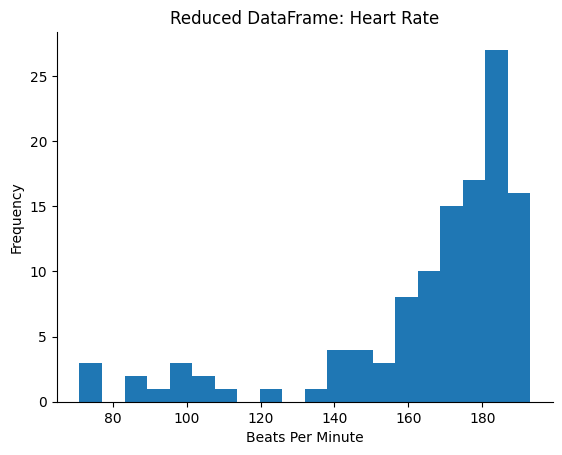

In [19]:
# Visualize Heart Rate Data from the reduced DF
df_token_limitation['heart_rate'].plot(kind='hist', bins=20, title='Reduced DataFrame: Heart Rate')
plt.xlabel('Beats Per Minute')
plt.gca().spines[['top', 'right',]].set_visible(False)

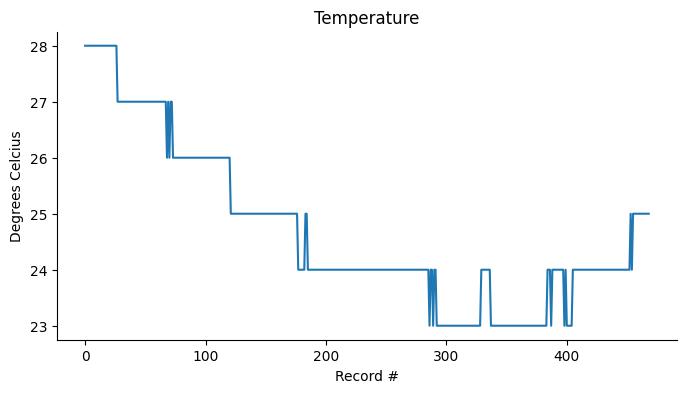

In [20]:
# @title Temperature Over Time Original Dataframe

from matplotlib import pyplot as plt
df['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

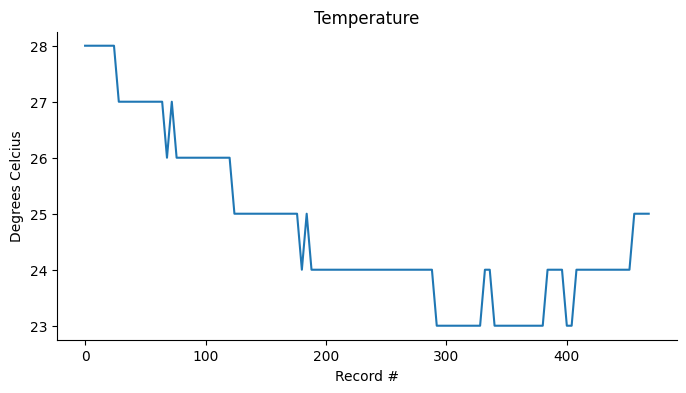

In [21]:
# @title Temperature Over Time Reduced Dataframe

from matplotlib import pyplot as plt
df_token_limitation['temperature'].plot(kind='line', figsize=(8, 4), title='Temperature')
plt.xlabel('Record #')
plt.ylabel('Degrees Celcius')
plt.gca().spines[['top', 'right']].set_visible(False)

In [22]:
df_for_llm = df_token_limitation

from openai import OpenAI

try:
    # Attempt to import the google.colab module to see if the program is running in Colab.
    from google.colab import userdata
    print("Running on Google Colab")
    client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

except ImportError:
    # The ImportError exception will be raised if the google.colab module is not found,
    # indicating that the program is not running inside Google Colab.
    import os
    print("Running outside of Google Colab")
    openai_api_key = os.environ['OPENAI_API_KEY']
    client = OpenAI(api_key=openai_api_key)

import tiktoken
enc = tiktoken.encoding_for_model("gpt-3.5-turbo-16k")

# Get the Dataframe to a String
df_string = df_for_llm.to_string()
print ("Number of tokens in input prompt ", len(enc.encode(df_string)))


Running on Google Colab
Number of tokens in input prompt  7566


In [23]:
# Manual Calculations using Math

#1. Distance in kilometers
#2. Time in hours:minutes
#3. Average Pace in minutes/km

activity_distance_metres = df_for_llm['distance'].max()
activity_distance_kilometers = activity_distance_metres / 1000
activity_time_seconds = df_for_llm['activity_duration_seconds'].max()
activity_time_minutes = activity_time_seconds / 60
activity_pace = activity_time_minutes /activity_distance_kilometers

print(activity_distance_kilometers)
print(activity_time_minutes)
print(activity_pace)

6.77517
41.03333333333333
6.056428596379623


In [24]:
# Feedback per KM
# Calculate average pace for the KM interval

range_min = 0
range_max = 1000
# Boolean indexing
import datetime

def to_unix_timestamp(date_time):
    return int(date_time.timestamp() * 1000)

per_km_df = df[(df_original['distance'] >= range_min) & (df_original['distance'] <= range_max)]

# Getting the index values
index_values = per_km_df.index

print(index_values)

per_km_distance_metres = per_km_df['distance'].max()
per_km_distance_kilometers = per_km_distance_metres / 1000
display(per_km_df)
per_km_time_seconds = per_km_df['timestamp'].max()
#per_km_time_minutes = to_unix_timestamp(per_km_time_seconds) / 60
per_km_time_seconds =  (to_unix_timestamp(per_km_df.iloc[-1]['timestamp']) - to_unix_timestamp(per_km_df.iloc[0]['timestamp'])) / 1000
per_km_time_minutes = per_km_time_seconds / 60
per_km_pace = per_km_time_minutes /per_km_distance_kilometers

print(per_km_distance_kilometers)
print(per_km_time_seconds)
print(per_km_time_minutes)

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105],
      dtype='int64', length=106)


,timestamp,distance,enhanced_speed,cycle_length16,heart_rate,cadence,temperature,fractional_cadence,135,136
0,2024-04-19 13:39:55+00:00,0.00,0.000,0.0,71,0,28,0.0,176,71
1,2024-04-19 13:39:56+00:00,0.00,0.000,0.0,74,0,28,0.0,176,74
2,2024-04-19 13:40:00+00:00,0.00,0.000,0.0,77,60,28,0.0,176,77
3,2024-04-19 13:40:03+00:00,0.00,0.000,NaN,81,55,28,0.5,176,81
4,2024-04-19 13:40:09+00:00,0.39,0.392,NaN,85,54,28,0.5,176,85
...,...,...,...,...,...,...,...,...,...,...
101,2024-04-19 13:47:50+00:00,945.27,2.659,NaN,158,80,26,0.5,72,158
102,2024-04-19 13:47:56+00:00,960.89,2.603,NaN,158,79,26,0.5,72,158
103,2024-04-19 13:48:02+00:00,974.23,1.764,NaN,155,80,26,0.0,88,155
104,2024-04-19 13:48:08+00:00,985.60,2.155,NaN,154,82,26,0.5,108,154


0.99946
499.0
8.316666666666666


In [25]:
instructPrompt = f"""
You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
You will provide 5 key takeaways for the treadmill running data that is provided, ordered as a list from 1 to 5.
You will also provide recommendations and affirmations on how to get better at these running workouts.
Please summarize the dataset that is represented as a string from a Pandas DataFrame.
You will also provide the following information as a table:
1. Distance in kilometers
2. Time in hours:minutes
3. Average Pace in minutes/km

From performing calculations, we already know the following:
1. Distance in kilometers is {activity_distance_kilometers}
2. Time in minutes is {activity_distance_kilometers}
3. Average Pace in minutes/km is {activity_pace}

Use this information to calibrate yourself.

The dataset is provided below. Also state if this person will be able to run across Canada."""

request = instructPrompt + df_string

In [26]:
chatOutput = client.chat.completions.create(model="gpt-3.5-turbo-16k",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": request}
                                                      ]
                                            )

In [27]:
!pip install google-generativeai

from pathlib import Path
import hashlib
import google.generativeai as genai


genai.configure(api_key=userdata.get('AI_STUDIO_KEY'))

# Set up the model
generation_config = {
  "temperature": 1,
  "top_p": 0.95,
  "top_k": 0,
  "max_output_tokens": 8192,
}

safety_settings = [
  {
    "category": "HARM_CATEGORY_HARASSMENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_HATE_SPEECH",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_SEXUALLY_EXPLICIT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
  {
    "category": "HARM_CATEGORY_DANGEROUS_CONTENT",
    "threshold": "BLOCK_MEDIUM_AND_ABOVE"
  },
]

model = genai.GenerativeModel(model_name="gemini-1.5-pro-latest",
                              generation_config=generation_config,
                              safety_settings=safety_settings)

uploaded_files = []
# def upload_if_needed(pathname: str) -> list[str]:
#   path = Path(pathname)
#   hash_id = hashlib.sha256(path.read_bytes()).hexdigest()
#   try:
#     existing_file = genai.get_file(name=hash_id)
#     return [existing_file]
#   except:
#     pass
#   uploaded_files.append(genai.upload_file(path=path, display_name=hash_id))
#   return [uploaded_files[-1]]

prompt_parts = [
  instructPrompt,
  df_string,
]

response = model.generate_content(prompt_parts)
print(response.text)
for uploaded_file in uploaded_files:
  genai.delete_file(name=uploaded_file.name)

## Treadmill Run Summary:

Based on the provided data, here are 5 key takeaways from your treadmill workout:

1. **Varied Pace:** Your pace varied significantly throughout the run, indicating potential interval training or changes in effort.
2. **Steady Cadence:** Your cadence remained relatively stable within a range of 70-80 steps per minute, suggesting good running form.
3. **Elevated Heart Rate:** Your heart rate was consistently high, especially in the latter half of the run, which could indicate a challenging workout or room for improving cardiovascular fitness.
4. **Consistent Temperature:** The temperature remained constant throughout the run, eliminating weather as a factor influencing performance.
5. **Shorter Activity Duration:** The activity duration suggests this may have been a shorter training run or a portion of a longer workout.

## Recommendations & Affirmations:

*   **Interval Training:** If you were performing interval training, analyze the effectiveness of your in

In [28]:
runningSummary = chatOutput.choices[0].message.content
print(runningSummary)

Based on the provided dataset, here are the key takeaways for the treadmill running data:

1. The total distance covered in the workout is 6.77517 kilometers.
2. The total workout duration is 6.77517 minutes.
3. The average pace for the workout is 6.056 minutes per kilometer.
4. The heart rate and cadence have slight variations throughout the workout, but no significant patterns or trends are observed.
5. The temperature and temperature effects remain consistent throughout the workout.

To get better at these running workouts, the following recommendations and affirmations can be considered:

1. Focus on maintaining a consistent pace throughout the workout to improve endurance and speed.
2. Incorporate interval training to vary the intensity and challenge the body in different ways.
3. Consider increasing the distance and duration gradually to gradually build endurance and strength.
4. Pay attention to heart rate and cadence variability to assess overall fitness and progress.
5. Make s

In [29]:
instructPromptForMetrics = f"""

You are an expert running coach and you are able to summarize running workout data that was captured from a Garmin wearable device. The 'distance' is in metres.
Please obtain the following information from the dataset that is represented as a string from a Pandas DataFrame. Some of the values have already been calculated, and are accurate:

1. Distance in kilometers, which we know is {activity_distance_kilometers}
2. Average Pace in minutes/km, which we know is {activity_pace}
3. Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].mean()}
4. Maximum Heart Rate, which is 'heart_rate' in the DataFrame. We know the average is {df_for_llm['heart_rate'].max()} beats per minute.
5. Elevation Gain in metres if it exist.
6. Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].mean()}
7. Maximum Temperature in degrees celcius, which we know the average is {df_for_llm['temperature'].max()}

You will return this as an ordered as a list from 1 to 5. Only provide the summarized information.

The dataset is provided below"""

requestForMetrics = df_string + instructPromptForMetrics

In [30]:
chatOutputForMetrics = client.chat.completions.create(model="gpt-4-0125-preview",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForMetrics}
                                                      ]
                                            )

In [31]:
metricsSummary = chatOutputForMetrics.choices[0].message.content
print(metricsSummary)

Based on the provided dataset and the known values, the summarized information is as follows:

1. Distance in kilometers: 6.77517
2. Average Pace in minutes/km: 6.056428596379623
3. Average Heart Rate: 165.22881355932202
4. Maximum Heart Rate: 193 beats per minute
5. Average Temperature: 24.703389830508474
6. Maximum Temperature: 28 degrees Celsius

Elevation gain is not directly provided in the given data excerpt, thus it cannot be summarized from the information available.


In [32]:
# Podcast title: "Running with Resilience"
instructPromptForAudio = """
Given metrics from a recent run, generate a 1-minute long podcast script. The title of the podcast is 'Running with Resilience.'
Your name is Terry, and you are an expert running coach. Provide an enthusiastic and motivational analysis of their performance, focusing on distance, pace, heart rate, and elevation gain. Include personalized affirmations and encouragement, emphasizing improvement and resilience. Keep the tone optimistic, supportive, and empowering, making the user feel celebrated for their achievements and motivated to continue their running journey."

Instructions:

1. Begin with a Warm Welcome: Start the podcast by greeting the listener and introducing yourself as their running coach. Express excitement about sharing their recent run achievements.
2. Analyze Performance Metrics:
    2.1. Distance: Commend the user on the distance covered, relating it to their dedication and progress.
    2.2. Pace: Reflect on the importance of consistency in pace, encouraging the user to keep moving forward at their own rhythm.
    2.3. Heart Rate: Highlight the effort shown by the heart rate data, connecting physical health to mental resilience.
    2.4. Elevation Gain: Use elevation gain to discuss overcoming challenges, likening hills to life's obstacles that the user is capable of conquering.
3. Incorporate Affirmations: Throughout the analysis, weave in affirmations such as "You are strong", "You are resilient", and "Every step is a victory". Encourage the listener to repeat these affirmations to foster a positive mindset.
4. Conclude with Motivational Encouragement: End the podcast by summarizing the user's achievements, reinforcing their potential for growth, and motivating them to continue their running journey. Encourage them to look forward to their next run with optimism and determination.
5. Keep It Brief and Engaging: Ensure the script is concise enough to fit into a 1-minute segment while being engaging and motivational.
6. Make it one entire transcript with only 1 host speaking. You will only provide what the host will say, and nothing else.
7. Do not use [User's average pace] or any variable names in brackets. Use actual metrics instead of placeholders.
Output Format:

A script suitable for a 1-minute podcast segment, formatted with clear sections for the introduction, analysis of each metric, affirmations, and a motivational conclusion.

The dataset is provided below"""

requestForAudio = metricsSummary + instructPromptForAudio

In [33]:
chatOutputForAudio = client.chat.completions.create(model="gpt-4",
                                            messages=[{"role": "system", "content": "You are a helpful assistant."},
                                                      {"role": "user", "content": requestForAudio}
                                                      ]
                                            )

In [34]:
runningSummaryForAudio = chatOutputForAudio.choices[0].message.content
print(runningSummaryForAudio)

"Hello Runners! This is Terry, your expert running coach. I'm thrilled to share with you some incredible achievements from our recent runs! So let's dive right in. 

Firstly, kudos to you for covering a whole distance of 6.77 kilometers! That's your stamina and progress showing right there. Remember, every kilometer is a testament to your strength.

Next, we look at your pace. You've been running at an average of just over 6 minutes per km. Amazing! It's not about speed, it's all about maintaining your rhythm. Push on, because you set the pace for your success.

Now, let's talk about your heart. With an average heart rate of 165 and even peaking at 193, it's evident you've been pushing the boundaries. And that's fantastic! It's a clear sign of your growing fitness and unyielding resilience. 

Remember, when it gets tough, repeat these affirmations, "I am strong. I am resilient. Every step is a victory." You really feel that power, don't you?

The mountains we climb and the obstacles we

In [36]:
import re

def remove_text_inside_brackets(text):
    # This pattern matches anything inside square brackets, including the brackets themselves.
    # It accounts for nested brackets as well.
    pattern = r'\[.*?\]'
    # Replace anything that matches the pattern with an empty string.
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

first_pass_text = remove_text_inside_brackets(runningSummaryForAudio)


def remove_host_instances(text):
    # This pattern matches the exact string "Host:".
    pattern = r'Host:'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

second_pass_text = remove_host_instances(first_pass_text)

def remove_empty_lines(text):
    # Split the text into lines, filter out empty or whitespace-only lines, and join back into a single string
    cleaned_text = "\n".join(line for line in text.splitlines() if line.strip())
    return cleaned_text


final_pass_text = remove_empty_lines(second_pass_text)
print(final_pass_text)

"Hello Runners! This is Terry, your expert running coach. I'm thrilled to share with you some incredible achievements from our recent runs! So let's dive right in. 
Firstly, kudos to you for covering a whole distance of 6.77 kilometers! That's your stamina and progress showing right there. Remember, every kilometer is a testament to your strength.
Next, we look at your pace. You've been running at an average of just over 6 minutes per km. Amazing! It's not about speed, it's all about maintaining your rhythm. Push on, because you set the pace for your success.
Now, let's talk about your heart. With an average heart rate of 165 and even peaking at 193, it's evident you've been pushing the boundaries. And that's fantastic! It's a clear sign of your growing fitness and unyielding resilience. 
Remember, when it gets tough, repeat these affirmations, "I am strong. I am resilient. Every step is a victory." You really feel that power, don't you?
The mountains we climb and the obstacles we over

In [37]:
from pathlib import Path
from openai import OpenAI
import datetime

date = datetime.datetime.now().strftime("%Y-%m-%d")
file_name = "podcast_"+ date +".mp3"
file_path_name = "/content/" + file_name

audioClient = OpenAI(api_key=openai_api_key)

speech_file_path = file_path_name
response = audioClient.audio.speech.create(
  model="tts-1",
  voice="echo",
  input=final_pass_text
)

response.stream_to_file(speech_file_path)

<ipython-input-37-1c3e8b2496c3>:18: DeprecationWarning: Due to a bug, this method doesn't actually stream the response content, `.with_streaming_response.method()` should be used instead
  response.stream_to_file(speech_file_path)


# Use Cloud Storage to Store the Files




In [ ]:
# Authenticate.

# if colabEnvironment == True:
#     from google.colab import auth
#     auth.authenticate_user()
#     # Install Cloud Storage FUSE.
#     !echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
#     !curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
#     !apt -qq update && apt -qq install gcsfuse

#     # Mount a Cloud Storage bucket or location, without the gs:// prefix.
#     mount_path = "running-llm-podcast"  # or a location like "my-bucket/path/to/mount"
#     local_path = f"/mnt/gs/{mount_path}"

#     !mkdir -p {local_path}
#     !gcsfuse --implicit-dirs {mount_path} {local_path}

In [ ]:
# if colabEnvironment == True:
    #!mv "/content/podcast.mp3" {file_path_name}
    # !cp {file_path_name} {local_path}
    #!ls -lh {local_path}